# `dPdI.ipynb`

Calculate dPdI from dIdV output, use to calculate NEP from PSD

In [1]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st
import scipy.signal as sg
from scipy import constants
import scipy

# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Initialize

In [132]:
folder_base = 'D:/B01_Runs'
run_num = 10
V = 100
run_name = f"Si_HV_ChAD_{V}V"

ibis_name = '20251030-0002'
didv_folder = f"dIdV {V}V"

didv_names = {
    0: '20251030-0002',
    5: '20251102-0002',
    10: '20251102-0002',
    15: '20251103-0002',
    20: '20251103-0002',
    50: '20251103-0002',
    100: '20251103-0002',
}

didv_name = didv_names[V]  # for dIdV results

analysis_num = 0
contact_free = False
detector_type = "Germanium" if 0 else "Silicion"

fs = 1_000_00  # sampling frequency of the data
pulse_length = 2_000  # length of a pulse template and noise

In [133]:
def read_PSD(filename, nsamples, trace_length):
    fs = nsamples/trace_length
    psd = np.loadtxt(filename)
    freqs, _ = qp.utils.fold_spectrum(qp.utils.fft(np.zeros(2*psd.size-2), fs = fs)[0], fs = fs)
    return freqs, psd

def read_noise(filename, nsamples, trace_length):
    fs = nsamples/trace_length
    noise = np.loadtxt(filename)
    freqs, _ = qp.calc_psd(np.zeros(len(noise)), fs=fs, folded_over=False)
    return freqs, noise

In [134]:
# Load up all the IbIs and dIdV fits

with open(folder_base + f'/Run{run_num}/IbIs/{ibis_name}_results.dat', 'rb') as f:
    
    ibis, ivfits, tr_fits = pickle.load(f)

if 1:
    with open(folder_base + f'/Run{run_num}/{didv_folder}/{didv_name}_results.dat', 'rb') as f:

        didvfit = pickle.load(f)

    channels = 'AD'
else:
    with open('C:/Users/MINER/Documents/B13 Cryolab/Run5/dIdV Data/20250605-0003_results.dat', 'rb') as f:

        didvfit = pickle.load(f)

    channels = 'ABCD'

if 0:
    with open(folder_base + '/Run6/dIdV Data/20250626_numerical_dpdi.dat', 'rb') as f:

        dpdi_num = pickle.load(f)

In [135]:
# Needed for NEP

psd_path = folder_base + f'/Run{run_num}/{run_name}/Analysis {analysis_num}/'
template_path = folder_base + f'/Run{run_num}/{run_name}/Analysis {analysis_num}/'
template_path2 = folder_base + f'/Run{run_num}/{run_name}/Analysis {analysis_num}/'

In [136]:
# Get Pulse Templates

templates_unnorm = {}
templates = {}
templates2 = {}

for c in channels:

    templates_unnorm2 = np.loadtxt(template_path2 + f'Average Templates 2/Ch {c} Average Template.txt')
    templates[c] = templates_unnorm2/templates_unnorm2.max()

    templates_unnorm[c] = np.loadtxt(template_path + f'Templates 2/Ch {c} Template.txt')
    templates2[c] = templates_unnorm[c]/templates_unnorm[c].max()

_, ts_template, ws_template = of.get_idx_tk_wn(templates[channels[0]].size, 1e-3) # templates = 2 ms traces

sampling_freq = templates[channels[0]].size/2e-3 # Hz

fs_template = ws_template/2/np.pi # frequencies for template frequency space [Hz]

In [137]:
# Needed for Phonon Collection Efficiency Calc

sumbcd = 1.54636e-8 # peak position in sum

if 1:
    base = os.path.join(folder_base, f"Run{run_num}")
    file_1 = os.path.join(base, f"Peak Locations (Analysis {analysis_num}).dat")

    with open(file_1, 'rb') as f:
        all_peak_locations = pickle.load(f)

    print("biases applied:", list(all_peak_locations.keys()))

    peak_positions = all_peak_locations[f"{V}V"]

else:  # manually
    # To find the bias and attempt which comes after the last "_" in run_name
    idx = []
    for i in range(len(run_name)):
        if run_name[i] == "_":
            idx.append(i)
    
    peak_loc = {"0V": 3e-6, "0V_2": 2.894e-6, "0V_3": 2.894e-6, "0V_4": 3.9e-6, "5V": 6e-6, "10V": 4.665e-6, "50V": 3.86e-6, "100V": 2.278e-6}  # before cuts except for 5V and 0V_4  # Run 9
    
    peak_positions = {
        'A': 1.574808589198864e-06, # 3.04e-6,
        'B': peak_loc[run_name[idx[-1] + 1:]],
        'C': 9.15586e-6,
        'D': 1.3894412015423057e-06,
    }

biases applied: ['0V', '5V', '10V', '15V', '20V', '50V', '100V']


In [138]:
# Calculate the true phonon energy

eff = 3 if detector_type == "Germanium" else 3.8  # eV / pair
lh_yield = 0.3
if contact_free:
    d_det = 25.4
    d_vac = 1
    epsilon_det = 16
    epsilon_vac = 1
    V_true = V * (d_det / epsilon_det) / (d_det / epsilon_det + d_vac / epsilon_vac)
else:
    V_true = V

peak_energy = 59.54 * (1 + lh_yield * V_true / eff) # energy of peak (keV)

In [139]:
print(peak_energy, "keV")
peak_positions

529.5926315789474 keV


{'A': np.float64(1.1682468318917325e-05),
 'D': np.float64(9.93983313770836e-06)}

In [140]:
didvfit["A"][3]["smallsignalparams"]

{'rsh': 0.02,
 'rp': np.float64(0.11031293849422495),
 'r0': np.float64(0.9595007196066158),
 'beta': np.float64(-1.153776432274679),
 'l': np.float64(0.9999981804503647),
 'L': np.float64(-1.3291967317391744e-07),
 'tau0': np.float64(-0.00030427195937424807),
 'gratio': np.float64(-30.15100196621509),
 'tau3': np.float64(1.2138860592519928e-05),
 'dt': np.float64(2.5259648454086615e-06)}

In [141]:
print(ivfits.rp[0])
tr_fits

[0.11031294 0.18405465]


,A,D
Rn,9.680474e-01,8.810958e-01
Rsc,-2.385613e-04,-2.311853e-03
loc,-3.621546e+01,-4.827434e+01
scale,4.878043e+00,8.699668e+00
R_op,9.595007e-01,8.569969e-01
I0,-4.440000e+01,-6.010000e+01
P0,1.891521e-09,3.095482e-09


### Noise and NEP

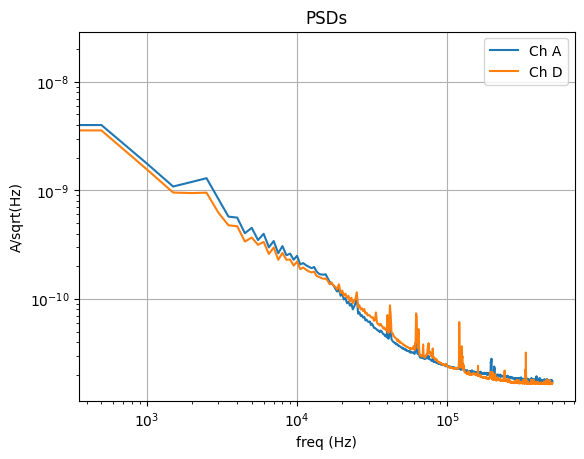

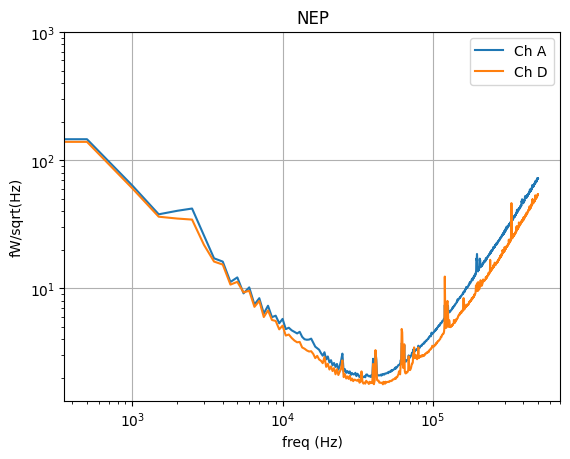

In [ ]:
# calculate NEP from PSD data and write to txt files


fig1, ax1 = plt.subplots(1,1)
ax1.set_title('PSDs')

fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')


dpdi = {}

for chan in channels:
    freqs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1_000_000, trace_length = 1)
    # freqs, psd = read_PSD(psd_path + f'Noise/Ch {chan} Noise.txt', nsamples = 1000_000, trace_length = 1)
    # psd = np.sqrt(psd)  # when reading Noise
    
    dpdi[chan], dpdi_err = qp.get_dPdI_with_uncertainties(freqs, didvfit[chan][3])

    #np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

    ax1.plot(freqs, psd, label = f'Ch {chan}')
    ax2.plot(freqs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')

N = len(dpdi[channels[0]])

ax1.grid()
ax2.grid()
ax1.loglog()
ax2.loglog()
ax1.set_xlabel('freq (Hz)')
ax2.set_xlabel('freq (Hz)')
ax1.set_ylabel('A/sqrt(Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax1.legend()
ax2.legend()



Text(0, 0.5, 'dPdI')

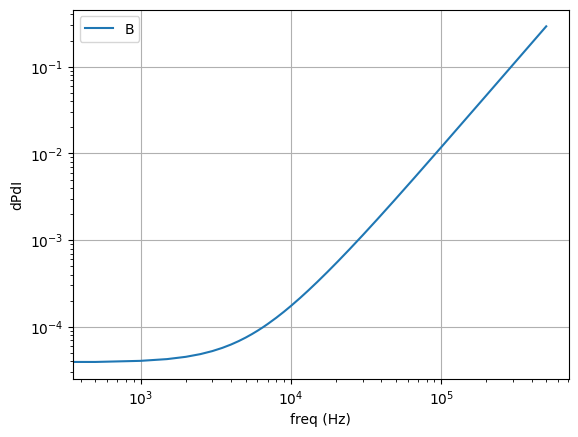

In [ ]:
plt.figure()
plt.loglog()
plt.grid()
for chan in channels:
    plt.plot(freqs, abs(dpdi[chan]), label = chan)
    #plt.plot(freqs, abs(dpdi_num[chan][:len(freqs)]), label = chan)

plt.legend()
plt.xlabel('freq (Hz)')
plt.ylabel('dPdI')

In [ ]:
dpdi_num[channels[0]].shape, dpdi[channels[0]].shape, freqs.shape, psd.shape

((10000,), (1000,), (1000,), (1000,))

In [133]:
N = dpdi_num[channels[0]].shape[0]
num_reslice = slice(N//2, N, 5)

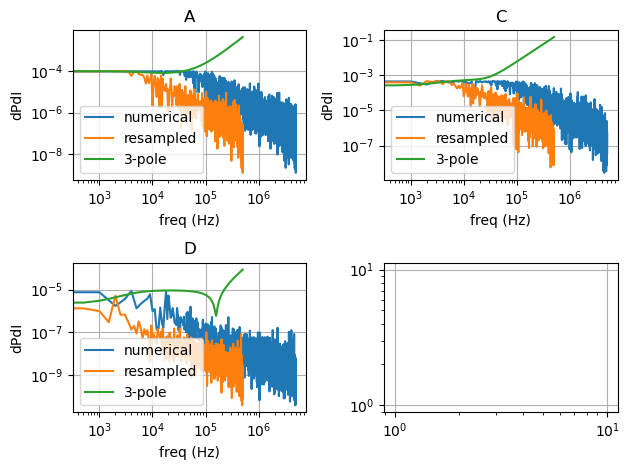

In [ ]:
fig, axs = plt.subplots(2, 2)
for ax in axs.flatten():
    ax.loglog()
    ax.grid()
for chan, ax in zip(channels, axs.flatten()):
    ax.plot(dpdi_num['freq'][N//2:], abs(dpdi_num[chan])[N//2:], label = 'numerical')
    ax.plot(freqs, abs(dpdi_num[chan][num_reslice]), label = 'resampled')
    wind = ax.axis()
    ax.plot(freqs, abs(dpdi[chan]), label = '3-pole')
    #ax.axis(wind)
    ax.set_title(chan)
    ax.legend()

    #plt.legend()
    ax.set_xlabel('freq (Hz)')
    ax.set_ylabel('dPdI')

fig.tight_layout()

In [ ]:
freqs.shape, dpdi_num['freq'].shape

if 0:
    for c in channels:
        dpdi[c] = dpdi_num[c][num_reslice]

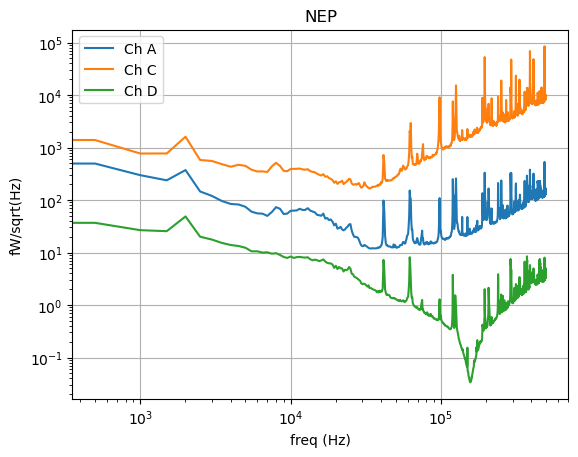

In [ ]:
# compare to theoretical NEP spectrum from mpyle Ch 3

with open('Sp.txt', 'rb') as f:
    Sp, fn = pickle.load(f)


fig2, ax2 = plt.subplots(1,1)
ax2.set_title('NEP')

for chan in channels:
    freqs, psd = read_PSD(psd_path + f'PSD/Ch {chan} PSD.txt', nsamples = 1000_000, trace_length = 1)

    ax2.plot(freqs, 1e15*psd*abs(dpdi[chan]), label = f'Ch {chan}')

#ax2.plot(fn, 1e15*np.sqrt(Sp), label = 'theoretical', color = 'k')


ax2.grid() 
ax2.loglog()
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('fW/sqrt(Hz)')
ax2.legend()



In [137]:
dpdi[channels[0]].shape, psd.shape

((1000,), (1000,))

In [138]:
# np.savetxt(psd_data_output_dir + f'Ch{chan}.txt', abs(dpdi[chan]))

### Templates and Energy

In [ ]:
if 0:
    # butterworth filter at 50 kHz
    filter_order = 10
    filter_freq = 50e3 # Hz
    butt = sg.butter(N = filter_order, Wn = filter_freq, btype = 'lowpass', output = 'sos', fs = fs)

    for c in channels:
        templates[c] = sg.sosfilt(butt, templates[c])
        templates[c] /= templates[c].max()

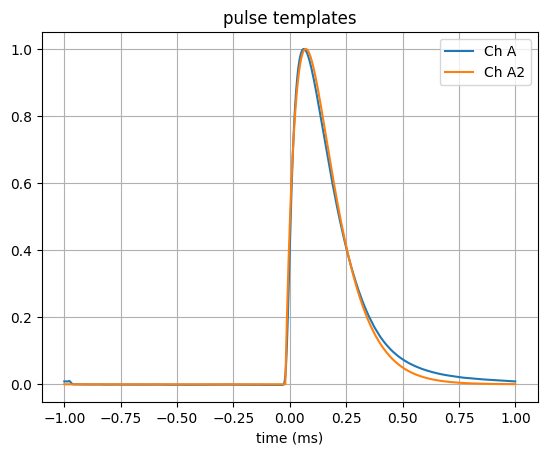

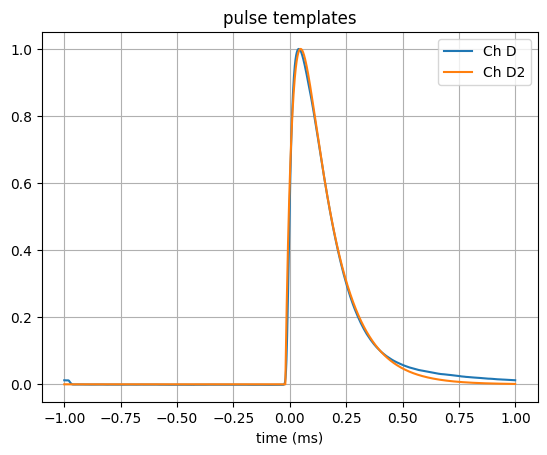

In [27]:
for c in channels:
    plt.figure()
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')
    plt.plot(ts_template*1e3, templates2[c], label = f'Ch {c}2')

    #plt.axis((-0.2, 0.2, 0.5,1.1))
    plt.title('pulse templates')
    plt.grid()
    plt.legend()
    plt.xlabel('time (ms)')

Text(0.5, 0, 'time (ms)')

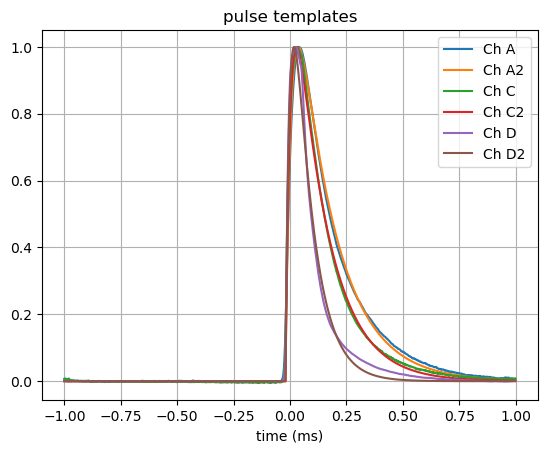

In [142]:
plt.figure()

for c in channels:
    plt.plot(ts_template*1e3, templates[c], label = f'Ch {c}')
    plt.plot(ts_template*1e3, templates2[c], label = f'Ch {c}2')

#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()
plt.legend()
plt.xlabel('time (ms)')

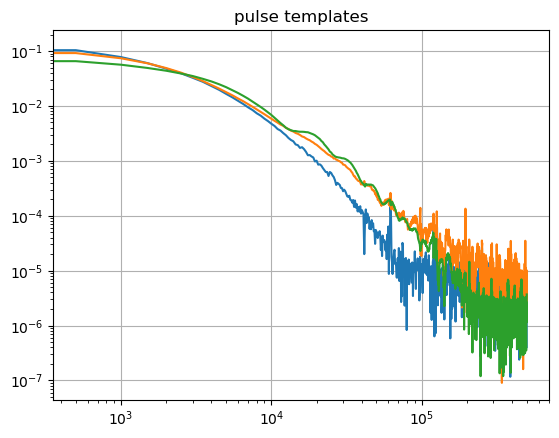

In [ ]:
plt.figure()

for c in channels:
    plt.plot(freqs, abs(of.fft(templates[c])[:templates[c].size//2]), label = f'Ch {c}')

plt.loglog()
#plt.axis((-0.2, 0.2, 0.5,1.1))
plt.title('pulse templates')
plt.grid()

In [ ]:
# convert templates to frequency domain and convert to power
pulse_power = {}
pulse_power_num = {}

template_energy = {} # energy (keV) of template
template_energy_num = {}

template_energy_2 = {}

edge_cut = 5

templates_60_keV = {}

for c in channels:

    templates_60_keV[c] = None#np.loadtxt(f"D:/B01_Runs/Run9/Ge_NTL_ChB_SWT_0V/Ch_{c}_60_keV_Template.txt")

    T = templates[c] if 1 else templates_60_keV[c]

    temp_w = np.fft.fft(T) # template current frequencies

    # dpdi_unfolded = np.hstack((dpdi[c][::-1], dpdi[c]))/2
    # dpdi_unfolded = np.hstack((abs(dpdi[c]), abs(dpdi[c])[::-1]))
    # pow_w = temp_w*dpdi_unfolded # template power frequencies

    dPdI, dPdI_err = qp.get_dPdI_with_uncertainties(np.fft.fftfreq(pulse_length, d=1/fs), didvfit[c][3])
    pow_w = temp_w * dPdI
    pulse_power[c] = np.fft.ifft(pow_w) # template power
    template_energy[c] = float(np.trapezoid(np.real(pulse_power[c])[edge_cut:-edge_cut], ts_template[edge_cut:-edge_cut]) / (1e3 * constants.e)) # energy of unit-height template in keV
    
    if 0:
        dpdi_unfolded_num = np.hstack((abs(dpdi_num[c][num_reslice]), abs(dpdi_num[c][num_reslice])[::-1]))
        pulse_power_num[c] = of.ifft(temp_w*dpdi_unfolded_num)
        template_energy_num[c] = float(np.trapezoid(np.real(pulse_power_num[c])[edge_cut:-edge_cut], ts_template[edge_cut:-edge_cut]) / (1e3 * constants.e)) # energy of unit-height template in keV
    
    print(f"Ch {c} Template Energy:", template_energy[c])

Ch A Template Energy: 16909057.810680203
Ch D Template Energy: 54846704.80436298


Text(0.5, 0, 'time (ms)')

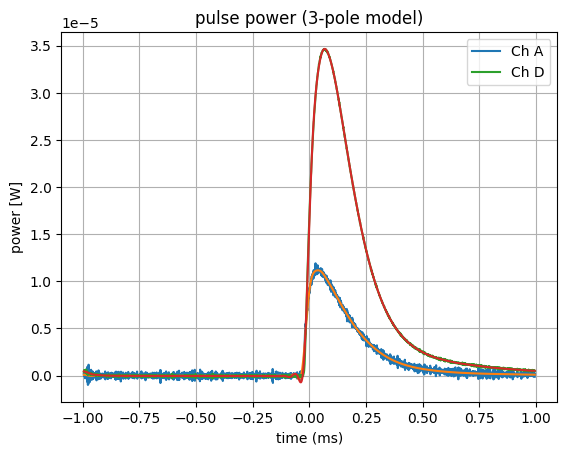

In [ ]:
plt.figure()

def butter_bandpass(lowcut, fs, order):
    nyq = fs / 2
    low = lowcut / nyq
    sos = scipy.signal.butter(order, low, output="sos")
    return sos

sos = butter_bandpass(lowcut=20_000, fs=fs, order=5)

for c in channels:
    x = ts_template[edge_cut:-edge_cut]*1e3
    y = np.real(pulse_power[c])
    y_filtered = scipy.signal.sosfiltfilt(sos, y)
    plt.plot(x, y[edge_cut:-edge_cut], label = f'Ch {c}')
    plt.plot(x, y_filtered[edge_cut:-edge_cut])
    # plt.plot(x, np.cumsum(y[edge_cut:-edge_cut]))
    # plt.plot(x, np.cumsum(y_filtered[edge_cut:-edge_cut]))

plt.title('pulse power (3-pole model)')
plt.grid()
plt.legend()
plt.ylabel('power [W]')
plt.xlabel('time (ms)')

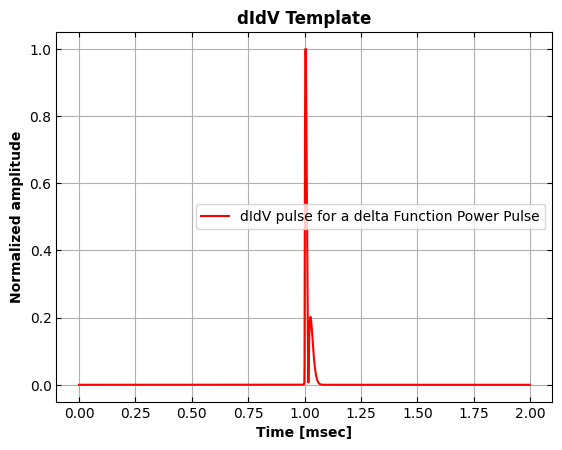

In [ ]:
# QETpy dIdV template using calculated dPdI parameters, assuming a dirac delta power deposit

pretrigger = 1e-3
tracelen = 2_000
didv_results = didvfit["D"][3]

# time array
dt = 1 / fs
time_array = np.arange(tracelen)*dt

# Current Template  (dirac delta power input)
template_didv = qp.get_didv_template(time_array, pretrigger, didv_results, lgcplot=False)
template_didv = template_didv/np.max(template_didv)

plt.plot(time_array*1e3, template_didv, color='r',
         label = "dIdV pulse for a delta Function Power Pulse")

plt.tick_params(which='both', direction='in', right=True, top=True)
plt.grid(which='minor', linestyle='dotted')
plt.grid(which='major')
plt.title('dIdV Template',fontweight='bold')
plt.xlabel('Time [msec]',fontweight='bold')
plt.ylabel('Normalized amplitude',fontweight='bold')
plt.legend(loc='best')
plt.show()

Text(0.5, 0, 'time (ms)')

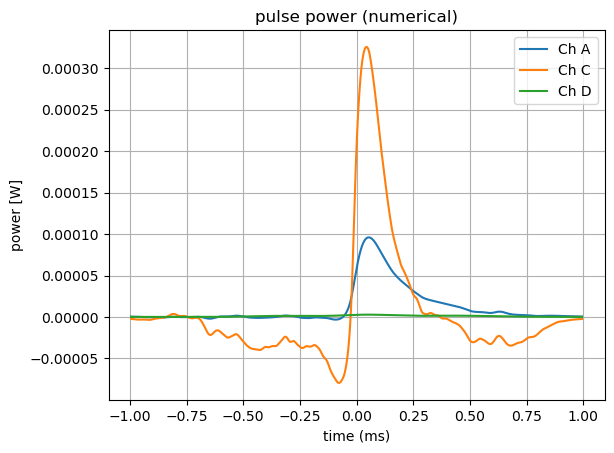

In [147]:
plt.figure()

for c in channels:
    plt.plot(ts_template[edge_cut:-edge_cut]*1e3, np.real(pulse_power_num[c][edge_cut:-edge_cut]), label = f'Ch {c}')

plt.title('pulse power (numerical)')
plt.grid()
plt.legend()
plt.ylabel('power [W]')
plt.xlabel('time (ms)')

In [87]:
template_energy

{'B': 94241005.68363823}

In [366]:
template_energy_num

{}

### Resolution

In [ ]:
resolutions = {}
resolutions2 = {}
resolutions3 = {}
resolutions4 = {}

trace_length = 2_000 # samples
pretrigger = 1e-3 # in seconds

# print('energy resolutions (phonon energy, ER energy)')
print('energy resolutions (eV)')
sg = 5

for c in channels:

    resolutions = {}

    freqs_1, psd = read_PSD(psd_path + f'PSD/Ch {c} PSD.txt', nsamples = 1_000_000, trace_length = 1) # Hz, A/sqrt(Hz)

    freqs_2, noise = read_noise(psd_path + f'Noise/Ch {c} Noise.txt', nsamples = 1_000_000, trace_length = 1) # Hz, A^2/Hz
    
    dPdI, dPdI_err = qp.get_dPdI_with_uncertainties(np.fft.fftfreq(trace_length, d=1/fs), didvfit[c][3])

    res = of.resolution(templates[c]/templates[c].max(), noise, 1.) * np.sqrt(500)
    phER = np.real(res * template_energy[c] * 1000) # eV
    # phER = res * 9472.37927766212 / peak_positions[c] # eV
    resolutions["Ph E (Utils)"] = f"{phER:.{sg}g}"
    ER = np.real(res * peak_energy / peak_positions[c]) * 1000 # eV
    resolutions["ER (Utils)"] = f"{ER:.{sg}g}"

    # nep = (abs(noise)*abs(dPdI))**2 # W^2/Hz
    # Jn = abs(psd)**2 # A^2/Hz
    #resolutions2[c] = of.resolution(np.real(pulse_power[c])/np.real(pulse_power[c]).max(), np.hstack((nep, nep[::-1]))/2, 1.)*template_energy[c]/np.real(pulse_power[c]).max() # of.resolution(pulse_power[c], np.hstack((nep, nep[::-1]))/2, 1.)
    #resolutions2[c] = of.resolution(pulse_power[c], np.hstack((nep, nep[::-1]))/2, 1.)*template_energy[c] # keV

    # Using dPdI
    # dpdistack = np.hstack((dpdi[c], dpdi[c][::-1]))/2
    # dPdI = dpdistack
    # dpdistack2 = np.hstack((dpdi_num[c][num_reslice], dpdi_num[c][num_reslice][::-1]))/2
    template_didv = qp.get_didv_template(np.arange(trace_length) * 1 / fs, pretrigger, didvfit[c][3])
    template_didv /= template_didv.max()

    ER_dPdI_didv = qp.utils.energy_resolution(noise, template_didv, dPdI, fs, lgc_current_template = True)
    ER_dPdI_pulse = qp.utils.energy_resolution(noise, templates[c], dPdI, fs, lgc_current_template = True) / np.sqrt(2)
    resolutions["W/ dPdI (dIdV Template)"] = f"{ER_dPdI_didv:.{sg}g}"
    resolutions["W/ dPdI (Template)"] = f"{ER_dPdI_pulse:.{sg}g}"

    # Using OF
    OF = qp.OptimumFilter(signal=np.zeros(2_000), template=templates[c], psd=noise, fs=fs)
    ER_OF = (OF.energy_resolution() / np.sqrt(2)) * peak_energy / peak_positions[c] * 1000 # eV
    resolutions["ER (OF)"] = f"{ER_OF:.{sg}g}"

    OF1x1_didv = qp.OF1x1(template=template_didv, psd=noise, sample_rate=fs, pretrigger_msec=1000, verbose=False)
    ofamp_resolution_didv = OF1x1_didv.get_amplitude_resolution()
    ofamp_to_ev_didv= qp.get_energy_normalization(time_array, template_didv, dpdi=dPdI, lgc_ev=True)
    energy_resolution_didv = ofamp_resolution_didv * ofamp_to_ev_didv
    resolutions["ER (dIdV Template)"] = f"{energy_resolution_didv:.{sg}g}"

    OF1x1_pulse = qp.OF1x1(template=templates[c], psd=noise, sample_rate=fs, pretrigger_msec=1000, verbose=False)
    ofamp_resolution_pulse = OF1x1_pulse.get_amplitude_resolution()
    ofamp_to_ev_pulse = qp.get_energy_normalization(time_array, templates[c], didv_result=didvfit[c][3], lgc_ev=True)
    energy_resolution_pulse = ofamp_resolution_pulse * ofamp_to_ev_pulse / np.sqrt(2)
    resolutions["ER (Template)"] = f"{energy_resolution_pulse:.{sg}g}"

    # print(f'{c}: {1e3*np.real(resolutions[c]):.5g} eV, {1e3*np.real(resolutions2[c]):.5g} eV, {np.real(resolutions3[c]):.5g} eV, {1e3*resolutions4[c]:.5g} eV')

    print(resolutions)

    if 0:#c == 'E':
        sn = of.fft(templates[c]/templates[c].max())
        J1 = np.hstack((Jn, Jn[::-1]))/2
        sn2 = of.fft(pulse_power[c]/pulse_power[c].max())
        J2 = np.hstack((nep, nep[::-1]))/2
        plt.figure(figsize = (4,3))
        plt.grid()
        plt.title(c)
        a = np.sqrt(abs(sn)**2/J1)/template_energy[c]
        b = np.sqrt(abs(sn2)**2/J2)*1.6e-16
        plt.plot(a)
        plt.plot(b)
        plt.loglog()
        ratio = a/b
        print(f'ratio: {np.real_if_close(ratio.mean()):.6g} +/- {np.real_if_close(ratio.std()):.6g}')

energy resolutions (eV)
{'Ph E (Utils)': '1576.8', 'ER (Utils)': '3652.8', 'W/ dPdI (dIdV Template)': '73.115', 'W/ dPdI (Template)': '1577.7', 'ER (OF)': '3653.6', 'ER (dIdV Template)': '73.12', 'ER (Template)': '1577.8'}
{'Ph E (Utils)': '3445.9', 'ER (Utils)': '2997.4', 'W/ dPdI (dIdV Template)': '77.106', 'W/ dPdI (Template)': '3448.5', 'ER (OF)': '2997.9', 'ER (dIdV Template)': '77.112', 'ER (Template)': '3448.8'}


In [132]:
# pyCRP

def rfft_corr(x):
    y=x
    y[1:]*=2
    return y

Tf = rfft_corr(np.fft.rfft(templates["B"]))
OF = np.dot(Tf.conjugate() / noise[:1_001], Tf)
1 / abs(np.sqrt(OF / 2_000 / 1e6))

np.float64(1.1481868170271687e-07)

In [139]:
# pyCRP Simplified

Tf = np.fft.fft(templates["B"])
OF = np.dot(Tf.conjugate() / noise, Tf)
1 / abs(np.sqrt(2 * OF / 2_000 / 1e6))

np.float64(1.1481868195997944e-07)

In [137]:
# QETpy Modified (factor of 2)

df = 1e6 / 2_000
s = np.fft.fft(templates["B"]) / 2_000 / df
OF = np.real(np.dot(s.conjugate() / noise, s)) * df
1 / np.sqrt(2 * OF)

np.float64(1.1481868195997944e-07)

In [135]:
# Utis Modified

sk = templates["B"]
Jn = noise
T = 1

sn = np.fft.fft(sk) / sk.size
OF = np.real_if_close(np.conj(sn) * sn / Jn)
1/np.sqrt((2 * OF).sum()) * np.sqrt(1_000_000 / sk.size)

np.complex128(1.1481868195997944e-07+1.3208864456036614e-26j)

### Phonon Collection Efficiency

In [ ]:
# calculate phonon collection efficiency

print('phonon collection efficiencies (3-pole)')
sum_eff = 0
for c in channels:
    if peak_positions[c]:
        unit_energy = peak_energy/peak_positions[c] # energy of pulse with unit height
        sum_eff += template_energy[c]/unit_energy
        print(c, ':', f'{100*template_energy[c]/unit_energy:.5g} %')

print(f'total: {100*sum_eff:.5g}%')

In [408]:
template_energy

{'B': 61474661.6130047}

In [ ]:
# calculate phonon collection efficiency

print('phonon collection efficiencies (numerical)')
sum_eff = 0
for c in channels:
    if peak_positions[c]:
        unit_energy = peak_energy/peak_positions[c] # energy of pulse with unit height
        sum_eff += template_energy_num[c]/unit_energy
        print(c, ':', f'{100*template_energy_num[c]/unit_energy:.5g} %')

print(f'total: {100*sum_eff:.5g}%')

Text(0.5, 0, 'time (ms)')

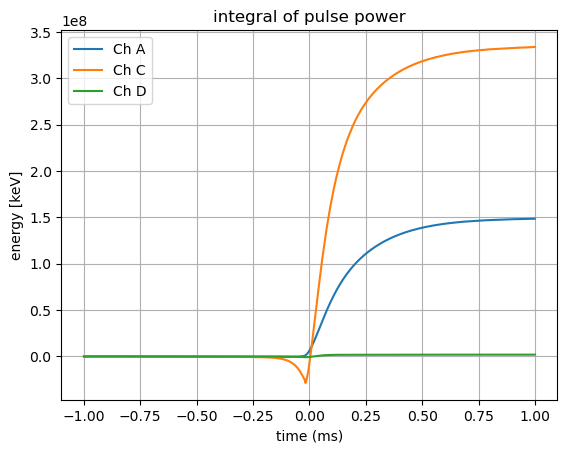

In [153]:
# cumulative energy
plt.figure()

for c in channels:
    plt.plot(1e3*ts_template[1:], si.cumulative_trapezoid(np.real(pulse_power[c])/1.6e-16, ts_template), label = f'Ch {c}')

plt.title('integral of pulse power')
plt.grid()
plt.legend()
plt.ylabel('energy [keV]')
plt.xlabel('time (ms)')

In [24]:
for c in channels:
    print(didvfit[c][3]['smallsignalparams']['rp'])

0.11031293849422495
0.18405465447346617


From [https://doi.org/10.1103/PhysRevD.104.032010](https://doi.org/10.1103/PhysRevD.104.032010) (citing Irwin & Hilton, 2005), the energy absorbed by TES can be inferred from circuit parameters, given shift in current $\delta I(t) = I_0 - I_s(t)>0$:

$$E \approx  \left(1 - \frac{2R_l}{R_l+R_0}\right) I_b R_{sh} \int \delta I(t)dt + R_l \int \delta I^2(t) dt$$



In [129]:
peak_positions

{'A': np.float64(1.25274003099043e-05),
 'D': np.float64(1.0451581408769742e-05)}

In [142]:
didvconfig = pd.read_csv(folder_base + f'/Run{run_num}/{didv_folder}/{didv_name}_config.txt', index_col = 0, header = None).to_dict()[1]

tot = 0
for c in channels:
    # i = channels.find(c)

    dI = abs(peak_positions[c] * templates[c]) # amps
    Ib = abs(didvconfig['off'+c]) / 1e6 # amps
    Rsh = didvconfig['rsh'] # Ohms
    
    # R0 = tr_fits["A"]["R_op"]
    R0 = didvfit[c][3]['smallsignalparams']['r0'] # Ohms

    # Rp = ivfits.rp[0][i]
    Rp = didvfit[c][3]['smallsignalparams']['rp'] # Ohms
    Rl = Rsh + Rp

    coeff = (1 - 2 * Rl / (Rl + R0)) * Ib * Rsh
    dP = coeff * dI + Rl * dI**2
    Joules = float(np.trapezoid(dP, ts_template))
    Epeak = Joules / constants.e / 1_000 # keV

    tot += Epeak / peak_energy

    print(c, ':', f'{100 * Epeak / peak_energy:.5g} %')

print(f'total: {100 * tot:.5g}%')

A : 8.5438 %
D : 9.0095 %
total: 17.553%


In [24]:
c = 'D'

def calculate_tes_energy(dI, t, Ib, Rsh, Rp, R0):
    Rl = Rsh + Rp
    coeff = (1 - 2 * Rl / (Rl + R0)) * Ib * Rsh
    dP = coeff * dI + Rl*dI**2
    return float(np.trapezoid(dP, t)) / constants.e

calculate_tes_energy(abs(peak_positions[c]*templates[c]), ts_template, abs(didvconfig['off'+c])/1e6, didvconfig['rsh'], didvfit[c][3]['smallsignalparams']['rp'], didvfit[c][3]['smallsignalparams']['r0'])

1692.4267490172494

In [157]:
dI.mean(), Ib

(np.float64(6.502559809705106e-07), 9.690000000000001e-05)

In [158]:
R0, Rl, Rp

(np.float64(0.20396529985547188),
 np.float64(0.3519888988782246),
 np.float64(0.3319888988782246))